### load model

In [38]:
import torch
import matplotlib
import torch.nn.functional as F
from pytorch.experiment_utils.generate_data import *
from matplotlib import pyplot as plt

import sys
sys.path.append('pytorch')
sys.path.append('pytorch/utils')

In [39]:
# !ls ../evaluation64/tl24xl0mt24_l4h4_lr25e-5_rlrp-copy/20220114-184122


#### reverse

In [75]:
# path = '../../data'
path = '/home/ayd98/Desktop/MIPT/Memory transformer/data24'
tr_iter = data_loader('train', path=path, task_name='reverse', batch_size=32,
                                        tgt_len=24, device='cpu')
gen = next(tr_iter)
data, target, l = next(gen)

# # acc = 1
# path = '../models/reverse_tl12xl0mt6.pt'

# # acc = 0.8
# path = '../models/reverse_tl12xl6mt0.pt'

# path = '../models/reverse_tl24mt24.pt'

# path = '../models/reverse_tl24xl24.pt'

path = '../models/reverse_tl8xl0mt8.pt'

model = torch.load(path, map_location='cpu')

In [76]:
# model.num_mem_tokens

#### copy

In [77]:
!ls ../models

copy_tl24xl0mt24.pt	   remote_logs_gpu8	  reverse_tl24xl24.pt
copy_tl24xl24mt0.pt	   reverse_tl12xl0mt6.pt  reverse_tl8xl0mt8.pt
copy_tl8xl0mt8.pt	   reverse_tl12xl6mt0.pt  reverse_tl8xl8.pt
copy_tl8xl8mt0_low_acc.pt  reverse_tl24mt24.pt


In [78]:
# path = '/home/ayd98/Desktop/MIPT/Memory transformer/data24'
# tr_iter = data_loader('train', path=path, task_name='copy', batch_size=32,
#                                         tgt_len=24, device='cpu')
# gen = next(tr_iter)
# data, target, l = next(gen)

# # # tl24mt24
# # # acc ~1
# # path = '../models/copy_tl24xl0mt24.pt'

# # # tl24mt24
# # # acc ~1
# # path = '../models/copy_tl24xl24mt0.pt'


# # acc ~1
# path = '../models/copy_tl8xl0mt8.pt'


# # # acc ~0.2
# # path = '../models/copy_tl8xl8mt0_low_acc.pt'

# model = torch.load(path, map_location='cpu')

#### retrieval

In [79]:
# # path = '../../data'
# path = '../../../x-transformers/data'
# tr_iter = data_loader('train', path=path, task_name='retrieval', batch_size=32,
#                                         tgt_len=10, device='cuda')
# gen = next(tr_iter)
# data, target, l = next(gen)

# # path = '../evaluation/tl10xl0mt0_lr1e-4_rlrp-retrieval/20220113-160611/model.pt'

# # #l1h1
# # path = '../evaluation/tl10xl0mt0_l1h1_lr1e-4_rlrp-retrieval/20220113-151239/model.pt'

# # #l2h2
# # path = '../evaluation/tl10xl0mt0_l2h2_lr3e-4_rlrp_as1-retrieval/20220113-101945/model.pt'

# #l6h4
# path = '../evaluation/tl5xl5mt0_l6h4_lr25e-5_rlrp-retrieval/20220117-103246/model.pt'


# model = torch.load(path).to(device='cuda')

forward

In [80]:
def get_attn_maps(model, data, target, mems=None, mem_tokens=model.num_mem_tokens):
    self = model

    if not mems: mems = model.init_mems(data.device)

    tgt_len = target.size(0)


    dec_inp = data

    word_emb = self.word_emb(dec_inp)

    mlen = mems[0].size(0) if mems is not None else 0

    # Concat with mem_tokens
    if mem_tokens is not None:
        word_emb = torch.cat((mem_tokens, word_emb), dim=0)
        if self.mem_at_end:
            word_emb = torch.cat((word_emb, mem_tokens), dim=0)

    qlen = word_emb.shape[0]
    klen = mlen + qlen
    if self.same_length:
        all_ones = word_emb.new_ones(qlen, klen)
        mask_len = klen - self.mem_len
        if mask_len > 0:
            mask_shift_len = qlen - mask_len
        else:
            mask_shift_len = qlen
        dec_attn_mask = (torch.triu(all_ones, 1+mlen)
                + torch.tril(all_ones, -mask_shift_len)).byte()[:, :, None] # -1
    else:
        dec_attn_mask = torch.triu(
            word_emb.new_ones(qlen, klen), diagonal=1+mlen).byte()

        if self.num_mem_tokens != 0:
            dec_attn_mask[:self.num_mem_tokens, mlen:mlen+self.num_mem_tokens] = 0
            dec_attn_mask[:self.num_mem_tokens, :mlen] = 1 - int(self.read_mem_from_cache)
            if self.mem_at_end:
                dec_attn_mask[-self.num_mem_tokens:, -self.num_mem_tokens:] = 0
                dec_attn_mask[-self.num_mem_tokens:, :mlen] = 1 - int(self.read_mem_from_cache)
        dec_attn_mask = dec_attn_mask[:,:,None]

    hids = []
    # if self.attn_type == 0: # default
    pos_seq = torch.arange(klen-1, -1, -1.0, device=word_emb.device, 
                           dtype=word_emb.dtype)
    if self.clamp_len > 0:
        pos_seq.clamp_(max=self.clamp_len)
    pos_emb = self.pos_emb(pos_seq)

    core_out = self.drop(word_emb)
    pos_emb = self.drop(pos_emb)

    hids.append(core_out)
    
    attn_maps = [] 
    for i, layer in enumerate(self.layers):
        print('got layer ', i)
        mems_i = None if mems is None else mems[i]
        core_out = layer(core_out, pos_emb, self.r_w_bias,
                self.r_r_bias, dec_attn_mask=dec_attn_mask, mems=mems_i)
        hids.append(core_out)
        
        w, r, r_w_bias, r_r_bias, attn_mask, mems1 = core_out, pos_emb, self.r_w_bias, self.r_r_bias, dec_attn_mask, mems_i
        
        qlen, rlen, bsz = w.size(0), r.size(0), w.size(1)

        self1 = layer.dec_attn
        if mems1 is not None:
            cat = torch.cat([mems1, w], 0)
            if self1.pre_lnorm:
                w_heads = self1.qkv_net(self1.layer_norm(cat))
            else:
                w_heads = self1.qkv_net(cat)
            r_head_k = self1.r_net(r)

            w_head_q, w_head_k, w_head_v = torch.chunk(w_heads, 3, dim=-1)
            w_head_q = w_head_q[-qlen:]
        else:
            if self1.pre_lnorm:
                w_heads = self1.qkv_net(self1.layer_norm(w))
            else:
                w_heads = self1.qkv_net(w)
            r_head_k = self1.r_net(r)

            w_head_q, w_head_k, w_head_v = torch.chunk(w_heads, 3, dim=-1)

        klen = w_head_k.size(0)

        w_head_q = w_head_q.view(qlen, bsz, self1.n_head, self.d_head)           # qlen x bsz x n_head x d_head
        w_head_k = w_head_k.view(klen, bsz, self1.n_head, self.d_head)           # qlen x bsz x n_head x d_head
        w_head_v = w_head_v.view(klen, bsz, self1.n_head, self.d_head)           # qlen x bsz x n_head x d_head

        r_head_k = r_head_k.view(rlen, self1.n_head, self.d_head)                # qlen x n_head x d_head

        #### compute attention score
        rw_head_q = w_head_q + r_w_bias                                         # qlen x bsz x n_head x d_head
        AC = torch.einsum('ibnd,jbnd->ijbn', (rw_head_q, w_head_k))             # qlen x klen x bsz x n_head

        rr_head_q = w_head_q + r_r_bias
        BD = torch.einsum('ibnd,jnd->ijbn', (rr_head_q, r_head_k))              # qlen x klen x bsz x n_head
        BD = self1._rel_shift(BD)

        # [qlen x klen x bsz x n_head]
        attn_score = AC + BD
        attn_score.mul_(self1.scale)

        #### compute attention probability
        if attn_mask is not None and attn_mask.any().item():
            if attn_mask.dim() == 2:
                attn_score = attn_score.float().masked_fill(
                    attn_mask[None,:,:,None].bool(), -float('inf')).type_as(attn_score)
            elif attn_mask.dim() == 3:
                attn_score = attn_score.float().masked_fill(
                    attn_mask[:,:,:,None].bool(), -float('inf')).type_as(attn_score)
        
        attn_prob = F.softmax(attn_score, dim=1)
#         attn_prob = self1.dropatt(attn_prob)
        
        attn_maps.append(attn_prob)
        
    return attn_maps
    

In [81]:
# attn_maps = get_attn_maps(model, data, target)

In [82]:
batch_size = 32
n_chunks = 6

mems = tuple()
if model.mem_tokens is not None:
    mem_tokens = model.mem_tokens.repeat(1, batch_size, 1)
else:
    mem_tokens = None

data_segs = torch.chunk(data, n_chunks)
target_segs = torch.chunk(target, n_chunks)
chunk_attn_maps = []

for i, (d, t) in enumerate(zip(data_segs, target_segs)):
    
    
    attn_maps = get_attn_maps(model, d, t, mems, mem_tokens)
    chunk_attn_maps.append(attn_maps)
    
    ret = model(d, t, *mems, mem_tokens=mem_tokens)
    if model.num_mem_tokens == 0:
        loss, mems = ret[0], ret[1:]
    else:
        mem_tokens, loss, mems = ret[0], ret[1], ret[2:]

    

    print(loss.mean())

got layer  0
got layer  1
got layer  2
got layer  3
tensor(3.5487, grad_fn=<MeanBackward0>)
got layer  0
got layer  1
got layer  2
got layer  3
tensor(3.5642, grad_fn=<MeanBackward0>)
got layer  0
got layer  1
got layer  2
got layer  3
tensor(5.4558, grad_fn=<MeanBackward0>)
got layer  0
got layer  1
got layer  2
got layer  3
tensor(1.6020e-05, grad_fn=<MeanBackward0>)
got layer  0
got layer  1
got layer  2
got layer  3
tensor(2.3665e-05, grad_fn=<MeanBackward0>)
got layer  0
got layer  1
got layer  2
got layer  3
tensor(2.3096e-05, grad_fn=<MeanBackward0>)


In [83]:
len(chunk_attn_maps), len(chunk_attn_maps[0])

(6, 4)

In [84]:
model.mem_len, model.num_mem_tokens

(0, 8)

In [85]:
name = 'images/reverse_tl8mt8.pdf'

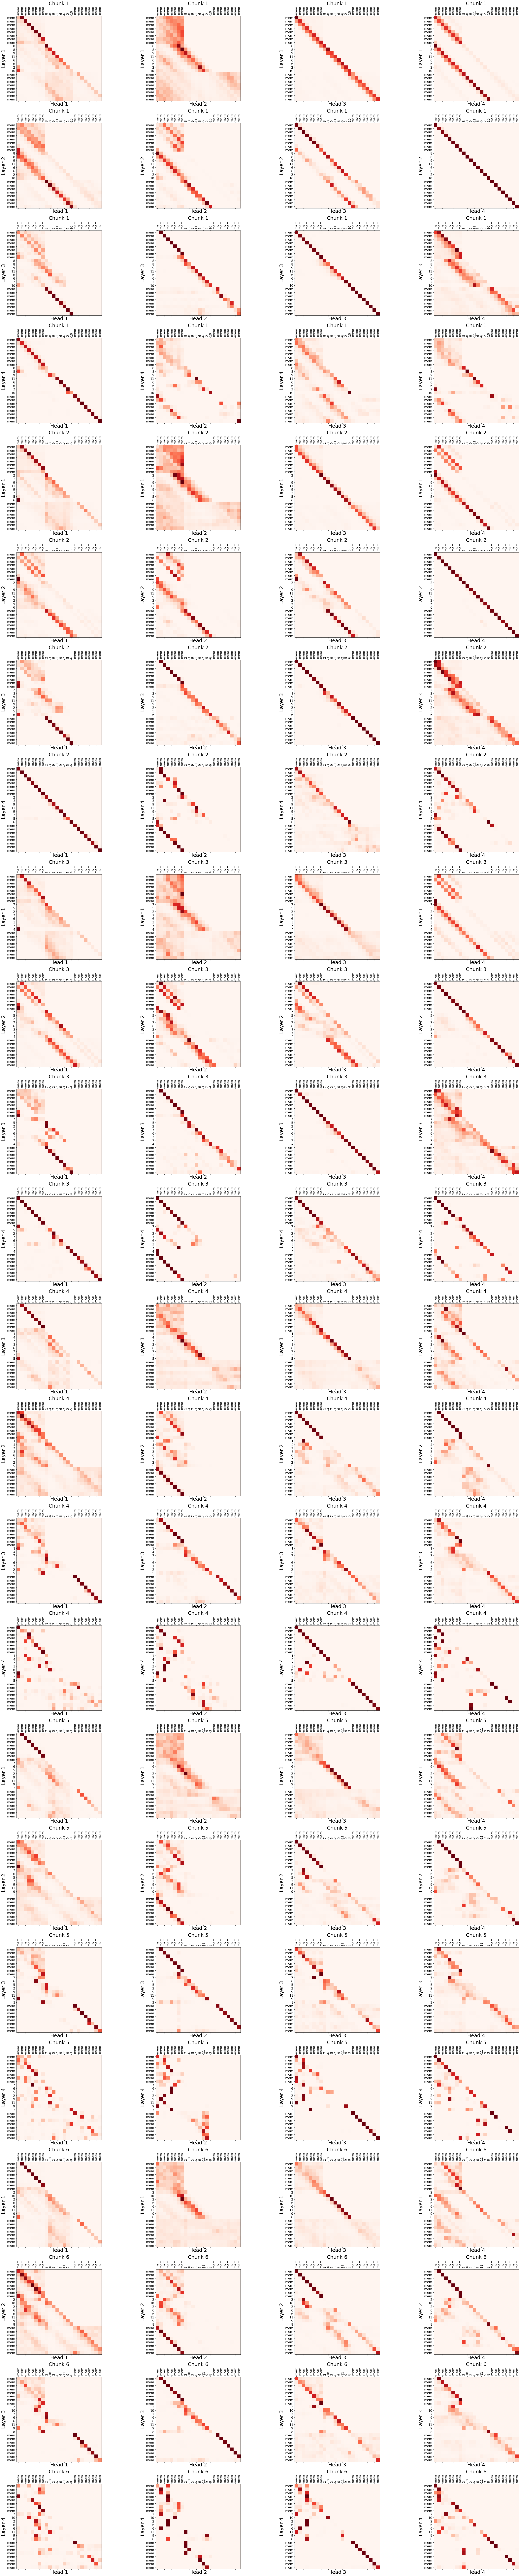

In [86]:
fontdict = {'fontsize': 25}
fd_small = {'fontsize': 16}

matplotlib.use('Agg')

batch_ind = 0
ticks = data[:, batch_ind].chunk(n_chunks)

ls = len(chunk_attn_maps[0])
hs = chunk_attn_maps[0][0].shape[-1]
n_chunks = len(chunk_attn_maps)
fig, axs = plt.subplots(n_chunks*ls, hs, figsize=(40, 30 * n_chunks))

for c, attn_maps in enumerate(chunk_attn_maps):
    # if c == 1:
    #     break
#     ls = len(attn_maps)
    hs = attn_maps[0].shape[-1]
    for l, layer_maps in enumerate(attn_maps):
        # if l == 1:
        #     break
        row = l + ls * c
        for h in range(layer_maps.shape[-1]):
            attn_map = layer_maps[:, :, batch_ind, h]

            if ls == hs == 1:
                axis = axs
            elif ls == 1:
                axis = axs[h]
            elif hs == 1:
                axis = axs[row]
            else: 
                axis = axs[row, h]
            axis.matshow(attn_map.cpu().detach().numpy(), cmap='Reds')
            
            axis.set_ylabel("Layer "+str(l+1), fontdict=fontdict)
        
            # if l == len(attn_maps)-1:
            axis.set_xlabel("Head "+str(h+1), fontdict=fontdict)
            
            # if l == 0:
            axis.set_title(f'Chunk {c+1}', fontdict=fontdict)
            
            
            tokens = ['mem'] * model.num_mem_tokens + list(ticks[c].numpy()) + ['mem'] * model.num_mem_tokens
            

            axis.set_yticks(range(len(tokens)))
            axis.set_yticklabels(tokens, fontdict=fd_small)
            if c > 0:
                tokens = ['mem'] * model.mem_len + tokens

            axis.set_xticks(range(len(tokens)))
            axis.set_xticklabels(tokens, rotation=90, fontdict=fd_small)

plt.tight_layout()

plt.savefig(name, facecolor='white', format='pdf')
# plt.show()

In [414]:
# fontdict = {'fontsize': 13}

# batch_ind = 0

# for c, attn_maps in enumerate(chunk_attn_maps):
#     ls = len(attn_maps)
#     hs = attn_maps[0].shape[-1]
#     fig, axs = plt.subplots(ls, hs, figsize=(20, 10))
#     for l, layer_maps in enumerate(attn_maps):
#         for h in range(layer_maps.shape[-1]):
#             attn_map = layer_maps[:, :, batch_ind, h]

#             if ls == hs == 1:
#                 axis = axs
#             elif ls == 1:
#                 axis = axs[h]
#             elif hs == 1:
#                 axis = axs[l]
#             else: 
#                 axis = axs[l, h]
#             axis.matshow(attn_map.cpu().detach().numpy(), cmap='Reds')
            
#             axis.set_ylabel("Layer "+str(l+1), fontdict=fontdict)
        
#             if l == len(attn_maps)-1:
#                 axis.set_xlabel("Head "+str(h+1), fontdict=fontdict)
            
#             if l == 0:
#                 axis.set_title(f'Chunk {c+1}', fontdict=fontdict)
#     plt.show()

In [299]:
# model._forward(data,mem_tokens = mem_tokens)[0].shape

In [294]:
# fontdict = {'fontsize': 10}

# batch_ind = 10
# ls = len(attn_maps)
# hs = attn_maps[0].shape[-1]
# fig, axs = plt.subplots(ls, hs, figsize=(20, 10))
# for l, layer_maps in enumerate(attn_maps):
# #     start = cn * param['enc_max_seq_len']
# #     end = start + param['enc_max_seq_len']
# #     tokens_x = ['[MEM]'] * num_memory_tokens + src_tokens_list[::-1][cn]
# #     tokens_y = tokens_x

# #     if len(chunk_maps) == 1:
# #         chunk_maps = [chunk_maps]
#     for h in range(layer_maps.shape[-1]):
#         attn_map = layer_maps[:, :, batch_ind, h]
        
#         if ls == hs == 1:
#             axis = axs
#         elif ls == 1:
#             axis = axs[h]
#         elif hs == 1:
#             axis = axs[l]
#         else: 
#             axis = axs[l, h]
#         axis.matshow(attn_map.cpu().detach().numpy(), cmap='Reds')
#         axis.set_xlabel("Head "+str(h+1), fontdict=fontdict)
#         axis.set_ylabel("Layer "+str(l+1), fontdict=fontdict)

# #         axs[row, i].set_xticks(range(len(tokens_x)))
# #         axs[row, i].set_xticklabels(tokens_x)
# #         axs[row, i].set_xticklabels(tokens_x,fontdict=fontdict, rotation=90)

# #         axs[row, i].set_yticks(range(len(tokens_y)))
# #         axs[row, i].set_yticklabels(tokens_y, fontdict=fontdict)

# #         axs[row, i].set_ylabel(f'Layer {l+1}. Chunk {cn+1}.', fontdict = fontdict)

In [195]:
len(attn_maps)

1

In [155]:
# model.layers[0].dec_attn(core_out, pos_emb, self.r_w_bias,
#             self.r_r_bias, attn_mask=dec_attn_mask, mems=mems_i)
w, r, r_w_bias, r_r_bias, attn_mask, mems = core_out, pos_emb, self.r_w_bias, self.r_r_bias, dec_attn_mask, mems_i
qlen, rlen, bsz = w.size(0), r.size(0), w.size(1)

self1 = model.layers[0].dec_attn
if mems is not None:
    cat = torch.cat([mems, w], 0)
    if self1.pre_lnorm:
        w_heads = self1.qkv_net(self1.layer_norm(cat))
    else:
        w_heads = self1.qkv_net(cat)
    r_head_k = self1.r_net(r)

    w_head_q, w_head_k, w_head_v = torch.chunk(w_heads, 3, dim=-1)
    w_head_q = w_head_q[-qlen:]
else:
    if self1.pre_lnorm:
        w_heads = self1.qkv_net(self1.layer_norm(w))
    else:
        w_heads = self1.qkv_net(w)
    r_head_k = self1.r_net(r)

    w_head_q, w_head_k, w_head_v = torch.chunk(w_heads, 3, dim=-1)

klen = w_head_k.size(0)

w_head_q = w_head_q.view(qlen, bsz, self1.n_head, self.d_head)           # qlen x bsz x n_head x d_head
w_head_k = w_head_k.view(klen, bsz, self1.n_head, self.d_head)           # qlen x bsz x n_head x d_head
w_head_v = w_head_v.view(klen, bsz, self1.n_head, self.d_head)           # qlen x bsz x n_head x d_head

r_head_k = r_head_k.view(rlen, self1.n_head, self.d_head)                # qlen x n_head x d_head

#### compute attention score
rw_head_q = w_head_q + r_w_bias                                         # qlen x bsz x n_head x d_head
AC = torch.einsum('ibnd,jbnd->ijbn', (rw_head_q, w_head_k))             # qlen x klen x bsz x n_head

rr_head_q = w_head_q + r_r_bias
BD = torch.einsum('ibnd,jnd->ijbn', (rr_head_q, r_head_k))              # qlen x klen x bsz x n_head
BD = self1._rel_shift(BD)

# [qlen x klen x bsz x n_head]
attn_score = AC + BD
attn_score.mul_(self1.scale)

#### compute attention probability
if attn_mask is not None and attn_mask.any().item():
    if attn_mask.dim() == 2:
        attn_score = attn_score.float().masked_fill(
            attn_mask[None,:,:,None].bool(), -float('inf')).type_as(attn_score)
    elif attn_mask.dim() == 3:
        attn_score = attn_score.float().masked_fill(
            attn_mask[:,:,:,None].bool(), -float('inf')).type_as(attn_score)

In [157]:
attn_score.shape

torch.Size([10, 10, 32, 2])

In [134]:
# hidden, new_mems = model._forward(data, mems=mems, mem_tokens=mem_tokens)

# num_mem = model.num_mem_tokens
# if model.num_mem_tokens > 0:
#     if model.mem_at_end:
#         pred_hid = hidden[-tgt_len - num_mem:-num_mem]
#         # mem_tokens_read = hidden[-tgt_len - 2*num_mem:-tgt_len - num_mem]
#         mem_tokens_write = hidden[-num_mem:]
#     else:
#         pred_hid = hidden[-tgt_len:]
#         mem_tokens_write = hidden[-tgt_len-num_mem:-tgt_len]
# else:
#     pred_hid = hidden[-tgt_len:]

In [135]:
pred_hid

tensor([[[-1.9532, -1.8821, -1.0881,  ...,  0.0000,  1.2782,  0.0061],
         [-1.6859,  1.8584,  0.0000,  ...,  0.8348, -0.7798,  0.4036],
         [-3.0759,  0.1327,  1.5251,  ...,  2.0039,  0.0731,  0.2712],
         ...,
         [-1.1547,  2.3262,  5.8595,  ...,  1.6864, -0.3181,  0.1501],
         [-0.3798,  4.9749, -0.7932,  ...,  0.1019, -0.3646, -0.5206],
         [-0.0496,  0.9676,  0.0915,  ...,  0.0000, -0.5638,  0.1200]],

        [[ 1.8450,  1.1259,  1.9215,  ..., -1.9701,  5.0149, -0.8256],
         [-3.9350,  4.0707,  0.3410,  ...,  2.7524,  1.5695,  0.3983],
         [-5.4039,  1.2346,  1.3648,  ...,  2.1260,  2.7881,  0.4112],
         ...,
         [ 0.0000, -1.4881,  2.1511,  ...,  1.7566,  2.2029, -0.3557],
         [-1.9413,  3.0423,  1.3793,  ...,  1.1176,  2.4531,  0.0000],
         [-3.8715,  3.2237, -0.5814,  ...,  2.8435,  0.0000, -0.8100]],

        [[-1.1954, -0.2763,  0.0000,  ..., -0.0099,  1.1094, -0.9892],
         [ 0.0000, -1.0579, -1.4567,  ...,  2

### start training

In [342]:
# !python3 parse_test.py --path ../evaluation
# !python3 parse_test.py --path ../evaluation64

In [33]:
import torch.nn as nn

class dummy:
    init=1


args = dummy
args.init = 'normal'
args.init_range = 0.1
args.init_std = 0.2


In [34]:
def init_weight(weight):
    if args.init == 'uniform':
        nn.init.uniform_(weight, -args.init_range, args.init_range)
    elif args.init == 'normal':
        nn.init.normal_(weight, 0.0, args.init_std)

def init_bias(bias):
    nn.init.constant_(bias, 0.0)
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            init_weight(m.weight)
        if hasattr(m, 'bias') and m.bias is not None:
            init_bias(m.bias)
    elif classname.find('AdaptiveEmbedding') != -1:
        if hasattr(m, 'n_emb_projs'):
            for i in range(m.n_emb_projs):
                if getattr(m, f'emb_projs_{i}') is not None:
                    nn.init.normal_(getattr(m, f'emb_projs_{i}'), 0.0, args.proj_init_std)
    elif classname.find('Embedding') != -1:
        if hasattr(m, 'weight'):
            init_weight(m.weight)
    elif classname.find('ProjectedAdaptiveLogSoftmax') != -1:
        if hasattr(m, 'cluster_weight') and m.cluster_weight is not None:
            init_weight(m.cluster_weight)
        if hasattr(m, 'cluster_bias') and m.cluster_bias is not None:
            init_bias(m.cluster_bias)
        if hasattr(m, 'n_out_projs'):
            for i in range(m.n_out_projs):
                if getattr(m, f'out_projs_{i}') is not None:
                    nn.init.normal_(getattr(m, f'out_projs_{i}'), 0.0, args.proj_init_std)
    elif classname.find('LayerNorm') != -1:
        if hasattr(m, 'weight'):
            nn.init.normal_(m.weight, 1.0, args.init_std)
        if hasattr(m, 'bias') and m.bias is not None:
            init_bias(m.bias)
    elif classname.find('TransformerLM') != -1:
        if hasattr(m, 'r_emb'):
            init_weight(m.r_emb)
        if hasattr(m, 'r_w_bias'):
            init_weight(m.r_w_bias)
        if hasattr(m, 'r_r_bias'):
            init_weight(m.r_r_bias)
        if hasattr(m, 'r_bias'):
            init_bias(m.r_bias)

In [47]:
from mem_transformer import MemTransformerLM

model = MemTransformerLM(10, n_layer=1, n_head=2, d_model=128,
        d_head=64, d_inner=128, dropout=0, dropatt=False,
        tie_weight=True, d_embed=128, div_val=1,
        tie_projs=False, pre_lnorm=False, tgt_len=24,
        ext_len=0, mem_len=0, cutoffs=[100],
        num_mem_tokens=0, mem_at_end=True, read_mem_from_cache=True, 
        same_length=False, attn_type=0,)
#         clamp_len=args.clamp_len, sample_softmax=args.sample_softmax)
model.apply(weights_init)
model.word_emb.apply(weights_init)

AdaptiveEmbedding(
  (emb_layers): ModuleList(
    (0): Embedding(10, 128)
  )
)

In [50]:
para_model = nn.DataParallel(model, device_ids=[0, 1], dim=1, output_device=0)

In [53]:
para_model.module.layers[0].dec_attn.qkv_net.weight

Parameter containing:
tensor([[ 0.0985,  0.1691, -0.0038,  ..., -0.2408, -0.1691, -0.1152],
        [ 0.1081,  0.3223,  0.1111,  ...,  0.1258,  0.3097,  0.2033],
        [-0.0880, -0.0667, -0.0200,  ...,  0.1696, -0.2326, -0.3018],
        ...,
        [ 0.0272,  0.1531, -0.3182,  ..., -0.1996, -0.0177, -0.0040],
        [-0.2096, -0.0216, -0.0216,  ...,  0.0793,  0.5224,  0.2413],
        [ 0.1567,  0.2344, -0.1599,  ...,  0.0427,  0.1003, -0.1154]],
       requires_grad=True)

In [49]:
model.layers[0].dec_attn.qkv_net.weight.mean(), model.layers[0].dec_attn.qkv_net.weight.std(), model.layers[0].dec_attn.qkv_net.weight

(tensor(0.0005, grad_fn=<MeanBackward0>),
 tensor(0.1994, grad_fn=<StdBackward>),
 Parameter containing:
 tensor([[ 0.0985,  0.1691, -0.0038,  ..., -0.2408, -0.1691, -0.1152],
         [ 0.1081,  0.3223,  0.1111,  ...,  0.1258,  0.3097,  0.2033],
         [-0.0880, -0.0667, -0.0200,  ...,  0.1696, -0.2326, -0.3018],
         ...,
         [ 0.0272,  0.1531, -0.3182,  ..., -0.1996, -0.0177, -0.0040],
         [-0.2096, -0.0216, -0.0216,  ...,  0.0793,  0.5224,  0.2413],
         [ 0.1567,  0.2344, -0.1599,  ...,  0.0427,  0.1003, -0.1154]],
        requires_grad=True))

### runs

In [64]:
!bash run_copy.sh train --work_dir ../evaluation64/test --lr 0.0001 --tgt_len 8 --eval_tgt_len 8 --mem_len 0 --num_mem_tokens 8 --device_ids 0

Run training...
[0]
Experiment dir : ../evaluation64/test-copy/20220113-165650
    - data : /home/admin/x-transformers/data24
    - dataset : copy
    - n_layer : 4
    - n_head : 4
    - d_head : 64
    - d_embed : 128
    - d_model : 128
    - d_inner : 256
    - dropout : 0.1
    - dropatt : 0.0
    - init : normal
    - emb_init : normal
    - init_range : 0.1
    - emb_init_range : 0.01
    - init_std : 0.02
    - proj_init_std : 0.01
    - optim : adam
    - lr : 0.0001
    - mom : 0.0
    - scheduler : dev_perf
    - warmup_step : 0
    - decay_rate : 0.5
    - lr_min : 1e-06
    - clip : 0.25
    - clip_nonemb : False
    - max_step : 250000
    - batch_size : 32
    - batch_chunk : 1
    - tgt_len : 8
    - eval_tgt_len : 8
    - ext_len : 0
    - mem_len : 0
    - num_mem_tokens : 8
    - not_tied : False
    - seed : 1111
    - cuda : True
    - adaptive : False
    - div_val : 1
    - pre_lnorm : False
    - varlen : False
    - multi_gpu : True
    - log_interval : 200
   

In [66]:
!bash run_copy.sh train --work_dir ../evaluation64/test --lr 0.0001 --tgt_len 8 --eval_tgt_len 8 --mem_len 0 --num_mem_tokens 8 --device_ids 0 1

Run training...
[0, 1]
Experiment dir : ../evaluation64/test-copy/20220113-165713
    - data : /home/admin/x-transformers/data24
    - dataset : copy
    - n_layer : 4
    - n_head : 4
    - d_head : 64
    - d_embed : 128
    - d_model : 128
    - d_inner : 256
    - dropout : 0.1
    - dropatt : 0.0
    - init : normal
    - emb_init : normal
    - init_range : 0.1
    - emb_init_range : 0.01
    - init_std : 0.02
    - proj_init_std : 0.01
    - optim : adam
    - lr : 0.0001
    - mom : 0.0
    - scheduler : dev_perf
    - warmup_step : 0
    - decay_rate : 0.5
    - lr_min : 1e-06
    - clip : 0.25
    - clip_nonemb : False
    - max_step : 250000
    - batch_size : 32
    - batch_chunk : 1
    - tgt_len : 8
    - eval_tgt_len : 8
    - ext_len : 0
    - mem_len : 0
    - num_mem_tokens : 8
    - not_tied : False
    - seed : 1111
    - cuda : True
    - adaptive : False
    - div_val : 1
    - pre_lnorm : False
    - varlen : False
    - multi_gpu : True
    - log_interval : 200


In [59]:
!bash run_wt103_base.sh train --gpu0_bsz -1 --batch_size 2 --device_ids 0 1

Run training...
[0, 1]
Experiment dir : LM-TFM-wt103/20220113-164320
Loading cached dataset...
    - data : ../../data/wt103
    - dataset : wt103
    - n_layer : 16
    - n_head : 10
    - d_head : 41
    - d_embed : 410
    - d_model : 410
    - d_inner : 2100
    - dropout : 0.1
    - dropatt : 0.0
    - init : normal
    - emb_init : normal
    - init_range : 0.1
    - emb_init_range : 0.01
    - init_std : 0.02
    - proj_init_std : 0.01
    - optim : adam
    - lr : 0.00025
    - mom : 0.0
    - scheduler : cosine
    - warmup_step : 0
    - decay_rate : 0.5
    - lr_min : 0.0
    - clip : 0.25
    - clip_nonemb : False
    - max_step : 200000
    - batch_size : 2
    - batch_chunk : 1
    - tgt_len : 150
    - eval_tgt_len : 150
    - ext_len : 0
    - mem_len : 150
    - num_mem_tokens : 0
    - not_tied : False
    - seed : 1111
    - cuda : True
    - adaptive : True
    - div_val : 4
    - pre_lnorm : False
    - varlen : False
    - multi_gpu : True
    - log_interval : 200

In [60]:
!bash run_wt103_base.sh train --gpu0_bsz -1 --batch_size 2 --device_ids 0

Run training...
[0]
Experiment dir : LM-TFM-wt103/20220113-164351
Loading cached dataset...
    - data : ../../data/wt103
    - dataset : wt103
    - n_layer : 16
    - n_head : 10
    - d_head : 41
    - d_embed : 410
    - d_model : 410
    - d_inner : 2100
    - dropout : 0.1
    - dropatt : 0.0
    - init : normal
    - emb_init : normal
    - init_range : 0.1
    - emb_init_range : 0.01
    - init_std : 0.02
    - proj_init_std : 0.01
    - optim : adam
    - lr : 0.00025
    - mom : 0.0
    - scheduler : cosine
    - warmup_step : 0
    - decay_rate : 0.5
    - lr_min : 0.0
    - clip : 0.25
    - clip_nonemb : False
    - max_step : 200000
    - batch_size : 2
    - batch_chunk : 1
    - tgt_len : 150
    - eval_tgt_len : 150
    - ext_len : 0
    - mem_len : 150
    - num_mem_tokens : 0
    - not_tied : False
    - seed : 1111
    - cuda : True
    - adaptive : True
    - div_val : 4
    - pre_lnorm : False
    - varlen : False
    - multi_gpu : True
    - log_interval : 200
  

In [72]:
!bash run_retrieval.sh train --work_dir ../evaluation/test --answer_size 1 --batch_size 2 --lr 0.0001 --tgt_len 10 --eval_tgt_len 10 --mem_len 0 --num_mem_tokens 0 --device_ids 0 2

Run training...
[0, 2]
Experiment dir : ../evaluation/test-retrieval/20220113-174715
    - data : /home/admin/x-transformers/data
    - dataset : retrieval
    - n_layer : 4
    - n_head : 2
    - d_head : 32
    - d_embed : 64
    - d_model : 64
    - d_inner : 128
    - dropout : 0.1
    - dropatt : 0.0
    - init : normal
    - emb_init : normal
    - init_range : 0.1
    - emb_init_range : 0.01
    - init_std : 0.02
    - proj_init_std : 0.01
    - optim : adam
    - lr : 0.0001
    - mom : 0.0
    - scheduler : dev_perf
    - warmup_step : 0
    - decay_rate : 0.5
    - lr_min : 1e-06
    - clip : 0.25
    - clip_nonemb : False
    - max_step : 250000
    - batch_size : 2
    - batch_chunk : 1
    - tgt_len : 10
    - eval_tgt_len : 10
    - ext_len : 0
    - mem_len : 0
    - num_mem_tokens : 0
    - not_tied : False
    - seed : 1111
    - cuda : True
    - adaptive : False
    - div_val : 1
    - pre_lnorm : False
    - varlen : False
    - multi_gpu : True
    - log_interval :

In [55]:
!bash run_retrieval.sh train --work_dir ../evaluation/test --lr 0.0001 --tgt_len 10 --eval_tgt_len 10 --mem_len 0 --num_mem_tokens 0 --device_ids 0

Run training...
[0]
Experiment dir : ../evaluation/test-retrieval/20220113-163700
    - data : /home/admin/x-transformers/data
    - dataset : retrieval
    - n_layer : 4
    - n_head : 2
    - d_head : 32
    - d_embed : 64
    - d_model : 64
    - d_inner : 128
    - dropout : 0.1
    - dropatt : 0.0
    - init : normal
    - emb_init : normal
    - init_range : 0.1
    - emb_init_range : 0.01
    - init_std : 0.02
    - proj_init_std : 0.01
    - optim : adam
    - lr : 0.0001
    - mom : 0.0
    - scheduler : dev_perf
    - warmup_step : 0
    - decay_rate : 0.5
    - lr_min : 1e-06
    - clip : 0.25
    - clip_nonemb : False
    - max_step : 250000
    - batch_size : 32
    - batch_chunk : 1
    - tgt_len : 10
    - eval_tgt_len : 10
    - ext_len : 0
    - mem_len : 0
    - num_mem_tokens : 0
    - not_tied : False
    - seed : 1111
    - cuda : True
    - adaptive : False
    - div_val : 1
    - pre_lnorm : False
    - varlen : False
    - multi_gpu : True
    - log_interval : 2

In [31]:
!bash run_retrieval.sh train --work_dir ../evaluation/tl10xl0mt0_lr3e-4_rlrp_as2 --answer_size 2 --lr 0.0003 --tgt_len 10 --eval_tgt_len 10 --mem_len 0 --num_mem_tokens 0 --device_ids 0 2

Run training...
[0, 2]
Experiment dir : ../evaluation/tl10xl0mt0_lr3e-4_rlrp_as2-retrieval/20220112-235057
    - data : /home/admin/x-transformers/data
    - dataset : retrieval
    - n_layer : 4
    - n_head : 4
    - d_head : 64
    - d_embed : 128
    - d_model : 128
    - d_inner : 256
    - dropout : 0.1
    - dropatt : 0.0
    - init : normal
    - emb_init : normal
    - init_range : 0.1
    - emb_init_range : 0.01
    - init_std : 0.02
    - proj_init_std : 0.01
    - optim : adam
    - lr : 0.0003
    - mom : 0.0
    - scheduler : dev_perf
    - warmup_step : 0
    - decay_rate : 0.5
    - lr_min : 1e-06
    - clip : 0.25
    - clip_nonemb : False
    - max_step : 250000
    - batch_size : 32
    - batch_chunk : 1
    - tgt_len : 10
    - eval_tgt_len : 10
    - ext_len : 0
    - mem_len : 0
    - num_mem_tokens : 0
    - not_tied : False
    - seed : 1111
    - cuda : True
    - adaptive : False
    - div_val : 1
    - pre_lnorm : False
    - varlen : False
    - multi_gpu : 

In [ ]:
!bash run_retrieval.sh train --work_dir ../evaluation/tl10xl0mt0_l2h2_lr3e-4_rlrp_as1 --n_layer 2 --n_head 2 --answer_size 1 --lr 0.0003 --tgt_len 10 --eval_tgt_len 10 --mem_len 0 --num_mem_tokens 0 --device_ids 0 2

Run training...
[0, 2]
Experiment dir : ../evaluation/tl10xl0mt0_l2h2_lr3e-4_rlrp_as1-retrieval/20220113-101945
    - data : /home/admin/x-transformers/data
    - dataset : retrieval
    - n_layer : 2
    - n_head : 2
    - d_head : 64
    - d_embed : 128
    - d_model : 128
    - d_inner : 256
    - dropout : 0.1
    - dropatt : 0.0
    - init : normal
    - emb_init : normal
    - init_range : 0.1
    - emb_init_range : 0.01
    - init_std : 0.02
    - proj_init_std : 0.01
    - optim : adam
    - lr : 0.0003
    - mom : 0.0
    - scheduler : dev_perf
    - warmup_step : 0
    - decay_rate : 0.5
    - lr_min : 1e-06
    - clip : 0.25
    - clip_nonemb : False
    - max_step : 250000
    - batch_size : 32
    - batch_chunk : 1
    - tgt_len : 10
    - eval_tgt_len : 10
    - ext_len : 0
    - mem_len : 0
    - num_mem_tokens : 0
    - not_tied : False
    - seed : 1111
    - cuda : True
    - adaptive : False
    - div_val : 1
    - pre_lnorm : False
    - varlen : False
    - multi_g

In [8]:
!bash run_reverse-debug.sh train --work_dir ../evaluation/tl12xl0mt12_deeper_lr1e-4_rlrp --lr 0.0001 --tgt_len 12 --eval_tgt_len 12 --mem_len 0 --num_mem_tokens 12 --device_ids 0 2

Run training...
[0, 2]
Experiment dir : ../evaluation/tl12xl0mt12_deeper_lr1e-4_rlrp-reverse/20220111-165124
    - data : /home/admin/x-transformers/data24
    - dataset : reverse
    - n_layer : 6
    - n_head : 3
    - d_head : 64
    - d_embed : 128
    - d_model : 128
    - d_inner : 256
    - dropout : 0.1
    - dropatt : 0.0
    - init : normal
    - emb_init : normal
    - init_range : 0.1
    - emb_init_range : 0.01
    - init_std : 0.02
    - proj_init_std : 0.01
    - optim : adam
    - lr : 0.0001
    - mom : 0.0
    - scheduler : dev_perf
    - warmup_step : 0
    - decay_rate : 0.5
    - lr_min : 0.0
    - clip : 0.25
    - clip_nonemb : False
    - max_step : 250000
    - batch_size : 32
    - batch_chunk : 1
    - tgt_len : 12
    - eval_tgt_len : 12
    - ext_len : 0
    - mem_len : 0
    - num_mem_tokens : 12
    - not_tied : False
    - seed : 1111
    - cuda : True
    - adaptive : False
    - div_val : 1
    - pre_lnorm : False
    - varlen : False
    - multi_gpu :

### Generate data

In [1]:
!python3 logs_to_tb.py --path ../evaluation --log_dir ../evaluation_tb

Processing  ../evaluation/tl42xl0mt0_lr1e-4_rlrp-retrieval/20220112-172604/log.txt
logs_to_tb.py:19: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  logs_to_tb(folder_path, log_dir)
Processing  ../evaluation/tl42xl0mt0_lr1e-4_rlrp-retrieval/20220112-172222/log.txt
Processing  ../evaluation/tl42xl0mt0_lr1e-4_rlrp-retrieval/20220112-172709/log.txt
Processing  ../evaluation/tl42xl0mt0_lr1e-4_rlrp-retrieval/20220112-172652/log.txt
Processing  ../evaluation/tl42xl0mt0_lr1e-4_rlrp-retrieval/20220112-172404/log.txt
Processing  ../evaluation/tl42xl0mt0_lr1e-4_rlrp-retrieval/20220112-172314/log.txt
Processing  ../evaluation/tl8xl0mt8_debug_lr2e-4_c-reverse/20220112-150822/log.txt
Processing  ../evaluation/tl12xl0mt12_debug_lr25e-5_c_bpd1-reverse/20220110-192507/log.txt
Processing  ../evaluation/tl12xl0mt12_debug_lr25e-5_c_bpd1-reverse/20220110-174336/log.txt
Processing  ../evaluation/tl12xl0mt12_debug_lr25e-5_c_bpd1-reverse/20220110-1

In [1]:
import numpy as np
from experiment_utils.generate_data import *

In [6]:
# ## reverse
# # !mkdir ../../data64

# BATCH_SIZE = 128
# ENC_SEQ_LEN = 64
# DEC_SEQ_LEN = 64
# NUM_TOKENS = 10
# TASK_NAME = 'reverse'
# path = '../../data64'
# np.random.seed(42)

# generator = reverse_generator(batch_size=BATCH_SIZE, enc_seq_len=ENC_SEQ_LEN, dec_seq_len=DEC_SEQ_LEN, num_tokens=NUM_TOKENS)
# generate_data(generator, path=path, task_name=TASK_NAME, train_size=100_000, test_size=10_000, val_size=2_000, batch_size=BATCH_SIZE) 

In [7]:
# ## copy
# # !mkdir ../../data64

# BATCH_SIZE = 128
# ENC_SEQ_LEN = 64
# DEC_SEQ_LEN = 128
# NUM_TOKENS = 10
# TASK_NAME = 'copy'
# path = '../../data64'
# np.random.seed(42)

# generator = copy_generator(batch_size=BATCH_SIZE, enc_seq_len=ENC_SEQ_LEN, dec_seq_len=DEC_SEQ_LEN, num_tokens=NUM_TOKENS)
# generate_data(generator, path=path, task_name=TASK_NAME, train_size=100_000, test_size=10_000, val_size=2_000, batch_size=BATCH_SIZE) 

In [ ]:
l = data_loader()

In [47]:
!bash run_reverse-debug.sh train --work_dir ../evaluation/tl12xl0mt12_debug_lr1e-4_c --lr 0.0001 --tgt_len 12 --eval_tgt_len 12 --mem_len 0 --num_mem_tokens 12 --device_ids 1 2

Run training...
[1, 2]
Experiment dir : ../evaluation/tl12xl0mt12_debug_lr1e-4_c-reverse/20220110-130119
    - data : /home/admin/x-transformers/data24
    - dataset : reverse
    - n_layer : 4
    - n_head : 4
    - d_head : 64
    - d_embed : 128
    - d_model : 128
    - d_inner : 256
    - dropout : 0.1
    - dropatt : 0.0
    - init : normal
    - emb_init : normal
    - init_range : 0.1
    - emb_init_range : 0.01
    - init_std : 0.02
    - proj_init_std : 0.01
    - optim : adam
    - lr : 0.0001
    - mom : 0.0
    - scheduler : constant
    - warmup_step : 0
    - decay_rate : 0.5
    - lr_min : 0.0
    - clip : 0.25
    - clip_nonemb : False
    - max_step : 250000
    - batch_size : 32
    - batch_chunk : 1
    - tgt_len : 12
    - eval_tgt_len : 12
    - ext_len : 0
    - mem_len : 0
    - num_mem_tokens : 12
    - not_tied : False
    - seed : 1111
    - cuda : True
    - adaptive : False
    - div_val : 1
    - pre_lnorm : False
    - varlen : False
    - multi_gpu : Tru

In [45]:
!bash run_reverse-debug.sh train --work_dir ../evaluation/tl24xl0mt24_debug --tgt_len 24 --eval_tgt_len 24 --mem_len 0 --num_mem_tokens 24 --device_ids 3 2

Run training...
[3, 2]
Experiment dir : ../evaluation/tl24xl0mt24_debug-reverse/20220108-165621
    - data : /home/admin/x-transformers/data24
    - dataset : reverse
    - n_layer : 4
    - n_head : 4
    - d_head : 64
    - d_embed : 128
    - d_model : 128
    - d_inner : 256
    - dropout : 0.1
    - dropatt : 0.0
    - init : normal
    - emb_init : normal
    - init_range : 0.1
    - emb_init_range : 0.01
    - init_std : 0.02
    - proj_init_std : 0.01
    - optim : adam
    - lr : 0.0005
    - mom : 0.0
    - scheduler : cosine
    - warmup_step : 0
    - decay_rate : 0.5
    - lr_min : 0.00025
    - clip : 0.25
    - clip_nonemb : False
    - max_step : 200000
    - batch_size : 32
    - batch_chunk : 1
    - tgt_len : 24
    - eval_tgt_len : 24
    - ext_len : 0
    - mem_len : 0
    - num_mem_tokens : 24
    - not_tied : False
    - seed : 1111
    - cuda : True
    - adaptive : False
    - div_val : 1
    - pre_lnorm : False
    - varlen : False
    - multi_gpu : True
    -

In [46]:
import os
path = '/data/home/admin/TXL/transformer-xl/evaluation'

def get_log_names(path):
    logs = []
    _, folders, names = next(os.walk(path))
    for folder in folders:
        folder_path = os.path.join(path, folder)
        logs += get_log_names(folder_path)

    names = [n for n in names if '.txt' in n]
    for name in names:
        filepath = os.path.join(path, name)
        logs.append(filepath)
    
    return logs

get_log_names(path) 


['/data/home/admin/TXL/transformer-xl/evaluation/tl12xl0mt6-reverse/20220107-135100/log.txt',
 '/data/home/admin/TXL/transformer-xl/evaluation/tl12xl0mt6-reverse/20220105-133841/log.txt',
 '/data/home/admin/TXL/transformer-xl/evaluation/tl12xl0mt6-reverse/20220107-165847/log.txt',
 '/data/home/admin/TXL/transformer-xl/evaluation/tl24xl0mt24-reverse/20220108-174137/log.txt',
 '/data/home/admin/TXL/transformer-xl/evaluation/tl24xl0mt24-reverse/20220108-160157/log.txt',
 '/data/home/admin/TXL/transformer-xl/evaluation/tl24xl0mt24-reverse/20220108-152407/log.txt',
 '/data/home/admin/TXL/transformer-xl/evaluation/tl24xl0mt24-reverse/20220105-121837/log.txt',
 '/data/home/admin/TXL/transformer-xl/evaluation/tl24xl0mt24-reverse/20220108-173854/log.txt',
 '/data/home/admin/TXL/transformer-xl/evaluation/tl24xl0mt24-reverse/20220108-160306/log.txt',
 '/data/home/admin/TXL/transformer-xl/evaluation/tl24xl0mt24-reverse/20220108-155300/log.txt',
 '/data/home/admin/TXL/transformer-xl/evaluation/tl24

In [ ]:
!bash run_reverse.sh train --work_dir ../evaluation/tl8xl0mt0 --tgt_len 8 --eval_tgt_len 8 --mem_len 0 --num_mem_tokens 0 --device_ids 1

Run training...
[1]
Experiment dir : ../evaluation/tl8xl0mt0-reverse/20220105-102032
    - data : /home/admin/x-transformers/data24
    - dataset : reverse
    - n_layer : 4
    - n_head : 4
    - d_head : 64
    - d_embed : 128
    - d_model : 128
    - d_inner : 256
    - dropout : 0.1
    - dropatt : 0.0
    - init : normal
    - emb_init : normal
    - init_range : 0.1
    - emb_init_range : 0.01
    - init_std : 0.02
    - proj_init_std : 0.01
    - optim : adam
    - lr : 0.00025
    - mom : 0.0
    - scheduler : cosine
    - warmup_step : 0
    - decay_rate : 0.5
    - lr_min : 0.0
    - clip : 0.25
    - clip_nonemb : False
    - max_step : 100000
    - batch_size : 32
    - batch_chunk : 1
    - tgt_len : 8
    - eval_tgt_len : 8
    - ext_len : 0
    - mem_len : 0
    - num_mem_tokens : 0
    - not_tied : False
    - seed : 1111
    - cuda : True
    - adaptive : False
    - div_val : 1
    - pre_lnorm : False
    - varlen : False
    - multi_gpu : True
    - log_interval : 2

In [ ]:
!bash run_reverse.sh train --work_dir ../evaluation/tl8xl12mt0 --tgt_len 8 --eval_tgt_len 8 --mem_len 12 --num_mem_tokens 0 --device_ids 1

In [ ]:
!bash run_reverse.sh train --work_dir ../evaluation/tl8xl0mt12 --tgt_len 8 --eval_tgt_len 8 --mem_len 0 --num_mem_tokens 12 --device_ids 1

In [32]:
!bash run_reverse-debug.sh train --device_ids 0 1

Run training...
[0, 1]
Experiment dir : ../reverse/debug-reverse/20211229-144300
    - data : /home/admin/x-transformers/data24
    - dataset : reverse
    - n_layer : 4
    - n_head : 4
    - d_head : 64
    - d_embed : 128
    - d_model : 128
    - d_inner : 256
    - dropout : 0.1
    - dropatt : 0.0
    - init : normal
    - emb_init : normal
    - init_range : 0.1
    - emb_init_range : 0.01
    - init_std : 0.02
    - proj_init_std : 0.01
    - optim : adam
    - lr : 0.00025
    - mom : 0.0
    - scheduler : cosine
    - warmup_step : 0
    - decay_rate : 0.5
    - lr_min : 0.0
    - clip : 0.25
    - clip_nonemb : False
    - max_step : 150000
    - batch_size : 32
    - batch_chunk : 1
    - tgt_len : 24
    - eval_tgt_len : 24
    - ext_len : 0
    - mem_len : 0
    - num_mem_tokens : 24
    - not_tied : False
    - seed : 1111
    - cuda : True
    - adaptive : False
    - div_val : 1
    - pre_lnorm : False
    - varlen : False
    - multi_gpu : True
    - log_interval : 20

In [18]:
!bash run_reverse_larger.sh train

Run training...
[0, 1]
Experiment dir : ../reverse/tl24_xl12_2912-reverse/20211229-140431
    - data : /home/admin/x-transformers/data24
    - dataset : reverse
    - n_layer : 4
    - n_head : 4
    - d_head : 64
    - d_embed : 128
    - d_model : 128
    - d_inner : 256
    - dropout : 0.1
    - dropatt : 0.0
    - init : normal
    - emb_init : normal
    - init_range : 0.1
    - emb_init_range : 0.01
    - init_std : 0.02
    - proj_init_std : 0.01
    - optim : adam
    - lr : 0.00025
    - mom : 0.0
    - scheduler : cosine
    - warmup_step : 0
    - decay_rate : 0.5
    - lr_min : 0.0
    - clip : 0.25
    - clip_nonemb : False
    - max_step : 120000
    - batch_size : 32
    - batch_chunk : 1
    - tgt_len : 24
    - eval_tgt_len : 24
    - ext_len : 0
    - mem_len : 12
    - num_mem_tokens : 0
    - not_tied : False
    - seed : 1111
    - cuda : True
    - adaptive : False
    - div_val : 1
    - pre_lnorm : False
    - varlen : False
    - multi_gpu : True
    - log_inte